# Importance sampling

## Takeaways and objectives from this notebook

We will focus on **importance sampling** as a method to compute expectations of functions with respect to distributions from which we are unable to sample but for which we can compute densities at any point.  Importance sampling allows us to compute the expectations but not draw samples from the distributions of interest.


## Importance sampling

The key idea of [importance sampling](https://en.wikipedia.org/wiki/Importance_sampling) is to use a **designed** probability distribution $q(x)$ to compute an estimate of an expectation
of a function $E[h(x)]$ where $x$ is distributed according to a distribution $p(x)$ which we can compute at any point but which we don't know
how to sample.

Assuming we want to evaluate the expectation of a function $h(x)$ with respect to the distribution $p(x)$

$$E[h(x)] = \int h(x) p(x) dx$$

we add the following terms and regroup:

$$E[h(x)] = \int h(x) p(x) dx = \int \frac{h(x)p(x)}{q(x)} q(x) dx = \int w(x) q(x) dx,$$

where

$$w(x) = h(x)p(x)/q(x)$$

can be considered a new 'function' whose expectation we compute with respect to $q(x)$. The fraction $p(x)/q(x)$ is called the **likelihood ratio** and is easily computable under our original assumption of being able to evaluate $p(x)$ anywhere.  Note that for this construction to work, we have to assume that $q(x) > 0$ whenever $h(x)p(x) \neq 0$. Under these conditions our estimate is unbiased, see [more detailed explanation](https://statweb.stanford.edu/~owen/mc/Ch-var-is.pdf).

The last integral can be again approximated with a sum over $x$ drawn from the distribution $q(x)$ from which we can sample (by construction)

$$E[h(x)] \approx \frac{1}{n}\sum_{i=1}^n w(x), \text{where we draw} \; x \sim q(x)$$

### What could go wrong in importance sampling?
- Note that the condition of convergence is simply that $q(x) > 0$ wherever $h(x)p(x) \neq 0$.  However what happens if $q(x) \approx 0$ in a large portion of the region where $h(x)p(x) \neq 0$?  
  - How would you recognize the above situation during sampling?
  - How would you resolve such a situation?
- What happens if you don't obtain enough samples for your estimate?

### Exercise

We are going to estimate the expected value of function $E[x]$, where $x \sim p(x)$, that is the expected value of the distribution $p(x)$. This means that our function $h(x)=x$, or simply the identity. Here is $p(x)$:

$$p(x) = \sqrt{\frac{1}{8\pi}}\exp \left (-\frac{(x-3)^2}{2} \right) + \sqrt{\frac{1}{16\pi}}\exp \left (-\frac{(x-6)^2}{4} \right ).$$

Below is a function `eval_p` that will evaluate the density of the function at any point $x$.

In [1]:
import numpy as np

# This function definition will also work on lists and np.arrays
def eval_p(x):
    return (1./8/np.pi)**0.5*np.exp(-0.5*(x-3)**2) + (1./16/np.pi)**0.5*np.exp(-0.25*(x-6)**2)

# Note: you can easily evaluate this function for any x but you can't easily sample random numbers
# from it. In Bayesian models, the same happens with products of data likelihoods and priors (and maybe factor potentials).

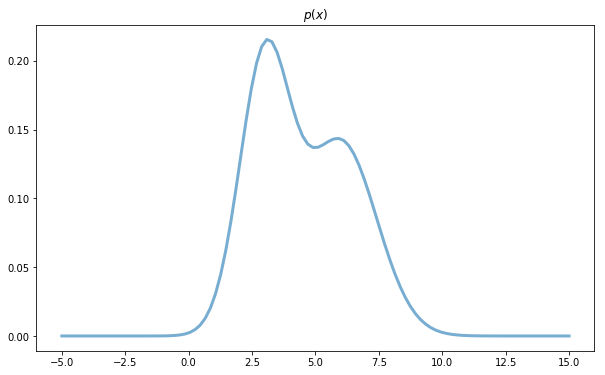

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(10,6))
ax = fig.gca()
x = np.linspace(-5, 15, 100)
ax.plot(x, eval_p(x), lw=3, alpha=0.6)
plt.title('$p(x)$')
plt.show()

### Designing the $q(x)$ distribution

Let's use the normal distribution for the sampling - it will become our $q(x)$ distribution. However we need to ensure that the space is sampled properly. Observe that q(x) > 0 everywhere by construction, so we are theoretically safe.

In [3]:
from scipy.stats import norm

# These are the (designed) parameters of our $q$ distribution.
q_mean = 0.
q_stdev = 1.

def designed_q(x):
    return norm.pdf(x, loc=q_mean, scale=q_stdev)

def sample_q(size):
    return norm.rvs(loc=q_mean,scale=q_stdev,size=size)

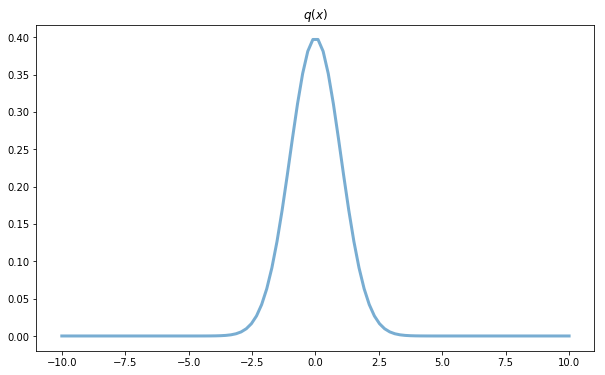

In [4]:
fig = plt.figure(figsize=(10,6))
ax = fig.gca()
x = np.linspace(-10, 10, 100)
ax.plot(x, designed_q(x), lw=3, alpha=0.6)
plt.title('$q(x)$')
plt.show()

### Exercise
Review the requirements for convergence of the importance sampling method above.  Are they satisfied for our choice of $q$ as shown in the figure above?

### Importance sampling code
The function below is the core of importance sampling. Compare this to the formulation above and convince yourself that the code below computes the required formula.

In [5]:
def compute_samples(n):
    return [x*eval_p(x)/designed_q(x) for x in sample_q(n)]

# Instead of just computing np.mean(compute_samples(n)), let's do something slightly different
# and compute the running estimate after each sample so that the final value will be equal to
# np.mean(compute_samples(n)) but we will have interim estimates as well.

def compute_running_estimates(n):
    return [s/(i+1.) for i,s in enumerate(np.cumsum(compute_samples(n)))]

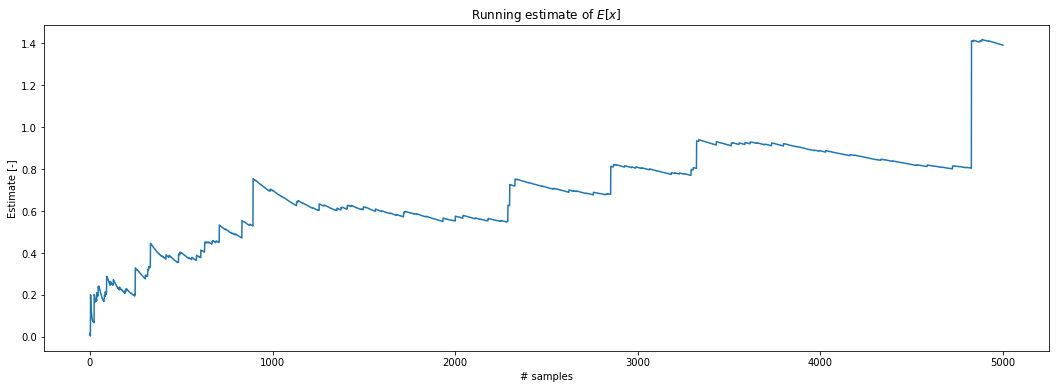

In [6]:
np.random.seed(12345678)
running_estimates = compute_running_estimates(5000)

plt.figure(figsize=(18,6))
plt.plot(running_estimates)
plt.title('Running estimate of $E[x]$')
plt.xlabel('# samples')
_ = plt.ylabel('Estimate [-]')

### Exercises
1. What is your estimate of the expected value?
2. What is happening in the graph above? Why are there such large jumps?
3. Are you confident in the final estimate given the sequence of estimates show in the figure?
4. What is under your control that you could modify to improve the stability of the estimate?

Hint: if you don't see how to continue, try plotting $q(x)$ and $p(x)$ on top of each other.

In [7]:
np.mean(compute_samples(10000))

1.6517876683597497

## Solution

It's possible to obtain the correct value by pasting the formula

$$E[x] = \int_{-\infty}^\infty x p(x) dx$$

into Wolfram Alpha where the formula above is substituted for $p(x)$.  After you compute the your estimate, go ahead and compare it to the true value.

### Intermittent large contributions

After observing the occasional large contributions, our solution was to increase the variance of the proposal distribution $q(x)$ to prevent infrequent samples that have a large likelihood ratio.

However, the Normal distribution has light tails and will generate extreme values infrequently.  This contributes to the problem of agetting large updates to our estimte.  A better candidate for the proposal distribution $q(x)$ may be the [Cauchy distribution](https://en.wikipedia.org/wiki/Cauchy_distribution) which has heavier tails and thus reduces the likelihood of samples with high likelihood ratios $p(x)/q(x)$.

Substitute the following code 

```python
from scipy.stats import cauchy

def designed_q(x):
    return cauchy.pdf(x, scale=5)

def sample_q(size):
    return cauchy.rvs(scale=5, size=size)
```

for the Normal proposal distribution and observe the effects in the exercise above.

### Conclusions and thinking material
- Remember we don't have the capability to draw samples from $p(x)$ - we don't do that anywhere in this notebook. Yet we can compute expectations with respect to it.
- It's not trivial to tune an importance sampler and incorrect settings can throw off the estimate.
- It's not easy to convince yourself that your estimate is good.  How did you do it?
- How would you add automatic diagnostics to your importance sampler? [hint: monitor likelihood ratio]
- It's always tricky to assess convergence. Bonus exercise: assess the variance of your estimate.